## 1. Data prep
assumes satellite data is available locally. \
(see edata_cred.py for script to setup Earthdata credentials if needed to download data) 

Data processing for super-greenhouse climatology paper (timeseries also available via project repository) 

Original AIRS L3 1deg data: https://disc.gsfc.nasa.gov/datasets/AIRS3STD_7.0/ 

Original CERES SSF1deg_day Aqua data: https://ceres.larc.nasa.gov/data/#ssf1deg-level-3 \
~20 yrs of data, from September 2002 to December 2022. 35S to 35N, ocean only.

Maura Dewey (maura.dewey@misu.su.se), 2023


In [10]:
import xarray as xr
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from datetime import datetime
from os import path

from SGE_utils import *

#import warnings
#warnings.filterwarnings('ignore')


In [11]:
#local data folders:
ceres_dp = '/nazko/home/mdewey/Data/CERES/SSF1deg_day/Aqua/'
airs_dp = '/nazko/home/mdewey/Data/AIRS/AIRS3STD/'

In [13]:
SGE_occ_all = []
SGE_occ_clr = []
SGE_str_all = []
SGE_str_clr = []
no_airs_ = []
clr_flg = []
all_flg = []

#get AIRS landseamask, lat, lon:
FILE_NAME = airs_dp + 'AIRS.2003.09.01.L3.RetStd_IR001.v7.0.3.0.G20174192131.hdf.nc4'
AIRS_latitude = xr.open_dataset(FILE_NAME)['Latitude'].rename({'Latitude':'lat'})
AIRS_longitude = xr.open_dataset(FILE_NAME)['Longitude'].rename({'Longitude':'lon'})

mask = xr.open_dataset('/home/mdewey/Data/CERES_SSF1deg-Day_Aqua-MODIS_Ed4.1_Subset_20220101-20221231.nc')['aux_ocean_daily'][0,:,:]
landmask = mask.where(mask==100,0)/100

#***should probably change to chuncks, pretty slow loop for whole timeseries*** 
for yr in range(2003,2023):
    
    #some files in different uvic folder:
    if yr==2022:
        ceres_files ='/home/mdewey/Data/CERES_SSF1deg-Day_Aqua-MODIS_Ed4.1_Subset_20220101-20221231.nc'
        AIRS_files = get_AIRS_files(airs_dp,'20220101','20221231')
    else:
        #get list of AIRS files which overlap current CERES files:
        ceres_files = sorted(glob(ceres_dp + '*_' + str(yr) + '*.nc'), key=lambda v: v.split('/')[-1:][0][-20:-12])
        CERES_start_date = ceres_files[0].split('/')[-1:][0][-20:-12]
        CERES_end_date = ceres_files[-1].split('/')[-1:][0][-11:-3]
        AIRS_files = get_AIRS_files(airs_dp, CERES_start_date, CERES_end_date)

    #get CERES data:
    OLR_all = xr.open_mfdataset(ceres_files,preprocess=olra_preprocess,combine='nested',concat_dim='time').drop_duplicates(dim='time')
    OLR_clr = xr.open_mfdataset(ceres_files,preprocess=olrc_preprocess,combine='nested',concat_dim='time').drop_duplicates(dim='time')
    CERES_dates_org = xr.open_mfdataset(ceres_files,preprocess=time_preprocess,combine='nested',concat_dim='time').drop_duplicates(dim='time')

    #normalize dates:
    OLR_all['time'] = OLR_all.indexes['time'].normalize()
    OLR_clr['time'] = OLR_clr.indexes['time'].normalize()

    SST_=[]
    TOTVAP_=[]

    #get AIRS data:
    for airs_fn in AIRS_files:
        file_date = datetime.strptime(airs_fn.split('/')[-1:][0][5:15],'%Y.%m.%d')
       
        #daily mean of ascending and desending modes
        sstA_ = xr.open_dataset(airs_fn)['SurfSkinTemp_A']
        sstA_clean = np.where(sstA_ != -9999.0, sstA_, np.NaN)
        sstD_ = xr.open_dataset(airs_fn)['SurfSkinTemp_D']
        sstD_clean = np.where(sstD_ != -9999.0, sstD_, np.NaN)
        sst_ = np.nanmean((sstA_clean, sstD_clean),axis=0)
        sst = xr.DataArray(sst_, 
        coords={'lat': AIRS_latitude,'lon': AIRS_longitude,'time': file_date}, 
        dims=["lat", "lon"])
        SST_.append(sst)
    
        h2oA_ = xr.open_dataset(airs_fn)['TotH2OVap_A']
        h2oA_clean = np.where(h2oA_ != -9999.0, h2oA_, np.NaN)
        h2oD_ = xr.open_dataset(airs_fn)['TotH2OVap_D']
        h2oD_clean = np.where(h2oD_ != -9999.0, h2oD_, np.NaN)
        h2o_ = np.nanmean((h2oA_clean, h2oD_clean),axis=0)
        h2o = xr.DataArray(h2o_, 
        coords={'lat': AIRS_latitude,'lon': AIRS_longitude,'time': file_date}, 
        dims=["lat", "lon"])
        TOTVAP_.append(h2o)

    #sort AIRS coordinates to match CERES data
    sst_airs = shift_latlon(xr.concat(SST_, dim='time')).rename('skint')
    h2o_airs = shift_latlon(xr.concat(TOTVAP_, dim='time')).rename('precipw')
    sst_airs['time'] = sst_airs.indexes['time'].normalize()
    h2o_airs['time'] = h2o_airs.indexes['time'].normalize()

    #check for days missing AIRS data and get from CERES:
    CERES_dates = OLR_all.time
    AIRS_dates = sst_airs.time
    missing_AIRS = np.setdiff1d(CERES_dates, AIRS_dates)
    if missing_AIRS.size != 0:
        ceres_aux_dates = CERES_dates_org[np.searchsorted(CERES_dates, missing_AIRS)]
        sst_ceres = xr.open_mfdataset(ceres_files,preprocess=sst_preprocess,combine='nested',concat_dim='time').sel(time=ceres_aux_dates).drop_duplicates(dim='time').rename('skint')
        h2o_ceres = xr.open_mfdataset(ceres_files,preprocess=h2o_preprocess,combine='nested',concat_dim='time').sel(time=ceres_aux_dates).drop_duplicates(dim='time').rename('precipw')*10
        sst_ceres['time'] = sst_ceres.indexes['time'].normalize()
        h2o_ceres['time'] = h2o_ceres.indexes['time'].normalize()
        #Combine AIRS and CERES surftemp and h2o data:
        SST = xr.concat([sst_airs, sst_ceres], dim='time').sortby('time')
        TPWV= xr.concat([h2o_airs,h2o_ceres], dim='time').sortby('time')
        no_airs_.append(ceres_aux_dates)
    else:
        SST = sst_airs
        TPWV = h2o_airs

    #apply landmask:
    OLR_all_ocn = OLR_all.where(landmask, np.nan)
    OLR_clr_ocn = OLR_clr.where(landmask, np.nan)
    SST_ocn = SST.where(landmask, np.nan)
    TPWV_ocn = TPWV.where(landmask, np.nan)

    #calculate SGE occurance and strength
    SGE_oc_all,SGE_st_all=SGE_threshold(SST_ocn,OLR_all_ocn,TPWV_ocn)
    SGE_oc_clr,SGE_st_clr=SGE_threshold(SST_ocn,OLR_clr_ocn,TPWV_ocn)

    #flag for where there are measured values
    cflg = xr.ones_like(OLR_clr_ocn)
    cflg = cflg.where(OLR_clr_ocn>0, 0)
    aflg = xr.ones_like(OLR_all_ocn)
    aflg = aflg.where(OLR_all_ocn>0, 0)

    #concat to xarray
    SGE_occ_all.append(SGE_oc_all)
    SGE_occ_clr.append(SGE_oc_clr)
    SGE_str_all.append(SGE_st_all)
    SGE_str_clr.append(SGE_st_clr)
    clr_flg.append(cflg)
    all_flg.append(aflg)

SGE_strength_clr = xr.concat(SGE_str_clr, dim='time')
SGE_strength_all = xr.concat(SGE_str_all, dim='time')
SGE_occurance_clr = xr.concat(SGE_occ_clr, dim='time')
SGE_occurance_all = xr.concat(SGE_occ_all, dim='time')
SGE_clr_flg =xr.concat(clr_flg, dim='time')
SGE_all_flg=xr.concat(all_flg, dim='time')

if len(no_airs_) != 0:
    no_airs_data = xr.concat(no_airs_, dim='time')
    no_airs_data['time'] = no_airs_data.indexes['time'].normalize()
    #drop days with No AIRS from all-sky timeseries: 
    #SGE_occurance_all = SGE_occurance_all.drop_sel(time = no_airs_data.coords['time'])
    #SGE_strength_all = SGE_strength_all.drop_sel(time = no_airs_data.coords['time'])


In [14]:
#calculate fraction of tropics area in SGE (ocean area between 35N/S)
xlon, ylat = np.meshgrid(SGE_strength_all.lon, SGE_strength_all.lat)
R = earth_radius(ylat)
dlat = np.deg2rad(np.gradient(ylat, axis=0))
dlon = np.deg2rad(np.gradient(xlon, axis=1))
dy = dlat * R
dx = dlon * R * np.cos(np.deg2rad(ylat))
area_grid = dy * dx * landmask
tot_area = area_grid.sum()

SGE_area_all = SGE_occurance_all*area_grid
SGE_area_clr = SGE_occurance_clr*area_grid
clr_area = (SGE_clr_flg*area_grid).sum(dim=['lat','lon'])
all_area = (SGE_all_flg*area_grid).sum(dim=['lat','lon'])

SGE_frac_all = SGE_area_all.sum(dim=['lat','lon'])/tot_area
SGE_frac_clr = SGE_area_clr.sum(dim=['lat','lon'])/tot_area
SGE_frac_clr2 = (SGE_area_clr.sum(dim=['lat','lon'])/clr_area).assign_attrs(description="fraction '2' is sum of SGE area/total measured area (ie points where a clear-sky values is reported), not total ocean area")
SGE_frac_all2 = SGE_area_all.sum(dim=['lat','lon'])/all_area

SGE_pw_all = (SGE_strength_all*area_grid).sum(dim=['lat','lon'])
SGE_pw_clr = (SGE_strength_clr*area_grid).sum(dim=['lat','lon'])

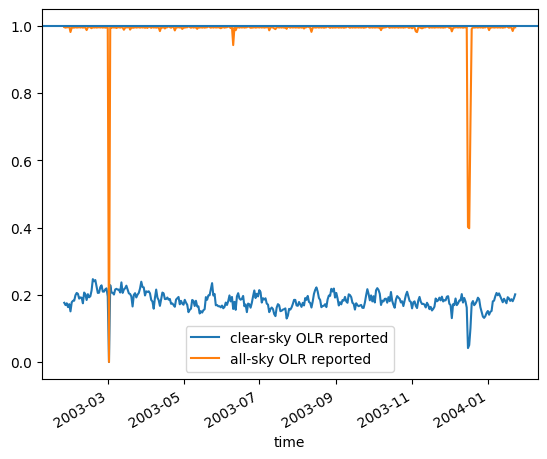

In [15]:
#check data availability
((SGE_clr_flg*area_grid).sum(dim=['lat','lon'])/tot_area).plot(label='clear-sky OLR reported')
((SGE_all_flg*area_grid).sum(dim=['lat','lon'])/tot_area).plot(label='all-sky OLR reported')
plt.axhline(y=1)
plt.legend()

In [16]:
#creat flag where there are no airs files for that day:
no_airs_flag = xr.zeros_like(SGE_frac_all)
no_airs_data = no_airs_data.time.dt.floor('D')
no_airs_flag = xr.where(np.isin(no_airs_flag.time, no_airs_data), 1, no_airs_flag)


In [17]:
#merge and save dataset
ds = xr.merge([SGE_occurance_all.rename('SGE_occ_all'), SGE_occurance_clr.rename('SGE_occ_clr'), SGE_strength_all.rename('SGE_str_all'), 
               SGE_strength_clr.rename('SGE_str_clr'), SGE_frac_all.rename('SGE_frac_all'), SGE_frac_clr.rename('SGE_frac_clr'),
               SGE_frac_all2.rename('SGE_frac_all2'), SGE_frac_clr2.rename('SGE_frac_clr2'), SGE_pw_all.rename('SGE_pw_all'), SGE_pw_clr.rename('SGE_pw_clr'),
               SGE_clr_flg.rename('clr_flag'), SGE_all_flg.rename('all_flag'), no_airs_flag.rename('airs_flag'), landmask.drop('time').rename('landmask')])

#assign attributes
ds['SGE_occ_all'].attrs={'description':'flag where SGC occurs for all-sky OLR (1=yes, 0=no)'}
ds['SGE_occ_clr'].attrs={'description':'flag where SGC occurs for clear-sky OLR (1=yes, 0=no)'}
ds['SGE_str_all'].attrs={'description':'difference between observed all-sky and SGC threshold OLR', 'units':'W m-2'}
ds['SGE_str_clr'].attrs={'description':'difference between observed clear-sky and SGC threshold OLR', 'units':'W m-2'}
ds['SGE_frac_all'].attrs={'description':'fraction of tropical ocean area identified as SGC in all-sky conditions'}
ds['SGE_frac_clr'].attrs={'description':'fraction of tropical ocean area identified as SGC in clear-sky conditions'}
ds['SGE_pw_all'].attrs={'description':'sum of SGE strength*grid area', 'units':'W'}
ds['SGE_pw_clr'].attrs={'description':'sum of SGE strength*grid area', 'units':'W'}
ds['clr_flag'].attrs={'description':'flag if clear-sky OLR is measured'}
ds['all_flag'].attrs={'description':'flag if all-sky OLR is measured'}
ds['airs_flag'].attrs={'description':'flag if there are no airs data for that day'}

ds.to_netcdf('SGE_timeseries_2002_2023_v4.nc')